In [25]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from core.data import pretraining_records
from sklearn.metrics import precision_recall_fscore_support
from presentation.scripts.backprop import NormedLSTMCell
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Something GPU-related is solved when using the following lines.
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)
        
def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()   

    metrics = pd.DataFrame([(w,s,tf.make_ndarray(t))for w,s,t in ea.Tensors('epoch_loss')],
                columns=['wall_time', 'step', 'value'])
    return metrics

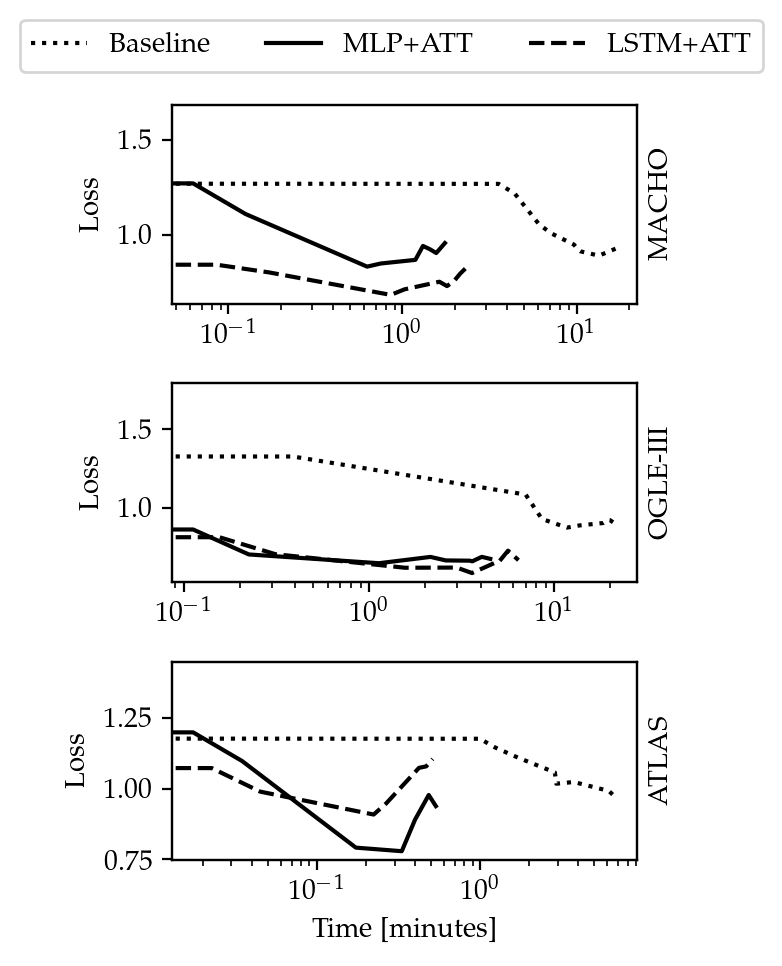

In [60]:
fig, axes = plt.subplots(3,1, sharey=False, sharex=False, figsize=(3,5), dpi=200, 
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},)

for i, name_exp in enumerate(['alcock', 'ogle', 'atlas']):
    for index, (name, ls) in enumerate(zip(['lstm', 'mlp_att', 'lstm_att'], [':', '-', '--'])):
    #     if name != 'lstm':continue

        val_metrics_list = []
        for fold_n in range(3):
            exp_folder = './latest/training_astromer/{}/fold_{}/{}_500/'.format(name_exp, fold_n, name_exp)
            val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
            val_metrics_list.append(val_metrics)

        min_epochs = min([f.shape[0] for f in val_metrics_list])
        val_metrics_list = [f.iloc[:min_epochs] for f in val_metrics_list]
        mean_values = np.mean([f['value'] for f in val_metrics_list], 0)

        val_metrics = pd.DataFrame()
        val_metrics['step'] = (val_metrics_list[0]['wall_time'] - val_metrics_list[0]['wall_time'].iloc[0])/60  

        val_metrics['value'] = mean_values   

        if name =='lstm': title_name = 'Baseline'
        if name =='mlp_att': title_name = 'MLP+ATT'
        if name =='lstm_att': title_name = 'LSTM+ATT'

        if name_exp == 'atlas' and name != 'lstm':
            axes[i].plot(val_metrics['step'].iloc[:-2], val_metrics['value'].iloc[:-2], label=title_name, linestyle=ls, color='k')
        else:
            axes[i].plot(val_metrics['step'], val_metrics['value'], label=title_name, linestyle=ls, color='k')

    ax2 = axes[i].twinx()
    if name_exp == 'alcock':
        ax2.set_ylabel('MACHO')
        ax2.set_yticks([])
#         axes[i].set_title('MACHO', fontsize=9)
        axes[i].legend(bbox_to_anchor=(1.3, 1.5), ncol=3)
        
    if name_exp == 'ogle':
        ax2.set_ylabel('OGLE-III')
        ax2.set_yticks([])
#         axes[i].set_title('OGLE-III', fontsize=9)
    if name_exp == 'atlas':
        ax2.set_ylabel('ATLAS')
        ax2.set_yticks([])
#         axes[i].set_title('ATLAS', fontsize=9)
        axes[i].set_xlabel('Time [minutes]')
    
    axes[i].set_ylabel('Loss')
    axes[i].set_xscale('log')

In [61]:
fig.savefig('./presentation/figures/learning_curves.pdf'.format(name_exp), format='pdf',  bbox_inches='tight')

In [24]:
n_epochs = {'lstm':[], 'lstm_att':[], 'mlp_att':[]}
for nsamples in [500]:
    for dataset in ['alcock', 'ogle', 'atlas']:
        for fold_n in range(3):
            exp_folder = './latest/training_astromer/{}/fold_{}/{}_{}/'.format(dataset, 
                                                                                                        fold_n,
                                                                                                        dataset,
                                                                                                        nsamples)

            for index, (name, ls) in enumerate(zip(['lstm', 'mlp_att', 'lstm_att'], [':', '-', '--'])):
            #     if name != 'lstm':continue

                val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
                min_loss_epoch = val_metrics['step'][np.argmin(val_metrics['value'])]
                if min_loss_epoch < 1000:               
                    n_epochs[name].append(min_loss_epoch)

In [122]:
'{:.0f} +- {:.0f}'.format(np.mean(n_epochs['lstm']), np.std(n_epochs['lstm']))

'207 +- 80'

In [123]:
'{:.0f} +- {:.0f}'.format(np.mean(n_epochs['lstm_att']), np.std(n_epochs['lstm_att']))

'97 +- 38'

In [124]:
'{:.0f} +- {:.0f}'.format(np.mean(n_epochs['mlp_att']), np.std(n_epochs['mlp_att']))

'94 +- 28'